The following example consists of a simple mechanics problem.

In [3]:
from ogs6py import ogs
import os

cwd = os.getcwd()
prj_name = "SimpleMechanics"
data_dir = os.environ.get('OGS_DATA_DIR', '../../../Data')
out_dir = os.environ.get('OGS_TESTRUNNER_OUT_DIR', '_out')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
os.chdir(out_dir)

model = ogs.OGS(PROJECT_FILE=f"{prj_name}.prj")
model.geo.add_geom(filename=f"{data_dir}/Mechanics/Linear/square_1x1.gml")
model.mesh.add_mesh(filename=f"{data_dir}/Mechanics/Linear/square_1x1_quad_1e2.vtu")
model.processes.set_process(name="SD",
                           type="SMALL_DEFORMATION",
                           integration_order="2",
                           solid_density="rho_sr",
                           specific_body_force="0 0")
model.processes.set_constitutive_relation(type="LinearElasticIsotropic",
                                        youngs_modulus="E",
                                        poissons_ratio="nu")
model.processes.add_process_variable(process_variable="process_variable",
                                   process_variable_name="displacement")
model.processes.add_process_variable(secondary_variable="sigma",
                                   output_name="sigma")
model.timeloop.add_process(process="SD",
                          nonlinear_solver_name="basic_newton",
                          convergence_type="DeltaX",
                          norm_type="NORM2",
                          abstol="1e-15",
                          time_discretization="BackwardEuler")
model.timeloop.set_stepping(process="SD", type="FixedTimeStepping",
                           t_initial="0",
                           t_end="1",
                           repeat="4",
                           delta_t="0.25")
model.timeloop.add_output(type="VTK",
                         prefix="blubb",
                         repeat="1",
                         each_steps="10",
                         variables=["displacement", "sigma"])
model.parameters.add_parameter(name="E", type="Constant", value="1")
model.parameters.add_parameter(name="nu", type="Constant", value="0.3")
model.parameters.add_parameter(name="rho_sr", type="Constant", value="1")
model.parameters.add_parameter(name="displacement0",
                              type="Constant",
                              values="0 0")
model.parameters.add_parameter(name="dirichlet0", type="Constant", value="0")
model.parameters.add_parameter(name="dirichlet1", type="Constant", value="0.05")
model.processvars.set_ic(process_variable_name="displacement",
                        components="2",
                        order="1",
                        initial_condition="displacement0")
model.processvars.add_bc(process_variable_name="displacement",
                        geometrical_set="square_1x1_geometry",
                        geometry="left",
                        type="Dirichlet",
                        component="0",
                        parameter="dirichlet0")
model.processvars.add_bc(process_variable_name="displacement",
                        geometrical_set="square_1x1_geometry",
                        geometry="bottom",
                        type="Dirichlet",
                        component="1",
                        parameter="dirichlet0")
model.processvars.add_bc(process_variable_name="displacement",
                        geometrical_set="square_1x1_geometry",
                        geometry="top",
                        type="Dirichlet",
                        component="1",
                        parameter="dirichlet1")
model.nonlinsolvers.add_non_lin_solver(name="basic_newton",
                                    type="Newton",
                                    max_iter="4",
                                    linear_solver="general_linear_solver")
model.linsolvers.add_lin_solver(name="general_linear_solver",
                              kind="lis",
                              solver_type="cg",
                              precon_type="jacobi",
                              max_iteration_step="10000",
                              error_tolerance="1e-16")
model.linsolvers.add_lin_solver(name="general_linear_solver",
                              kind="eigen",
                              solver_type="CG",
                              precon_type="DIAGONAL",
                              max_iteration_step="10000",
                              error_tolerance="1e-16")
model.linsolvers.add_lin_solver(name="general_linear_solver",
                              kind="petsc",
                              prefix="sd",
                              solver_type="cg",
                              precon_type="bjacobi",
                              max_iteration_step="10000",
                              error_tolerance="1e-16")
try:
    model.write_input()
    model.run_model(logfile="out.txt")
except Exception as inst:
    print(f"{type(inst)}: {inst.args[0]}")

os.chdir(cwd)
from datetime import datetime
print(datetime.now())

OGS finished with project file SimpleMechanics.prj.
Execution took 0.11316180229187012 s
2022-10-25 23:43:04.605755


slight changes of interpolated values if defaults are/were used.
slight changes of interpolated values if defaults are/were used.
slight changes of interpolated values if defaults are/were used.
slight changes of interpolated values if defaults are/were used.


Text(0, 0.5, 'u')

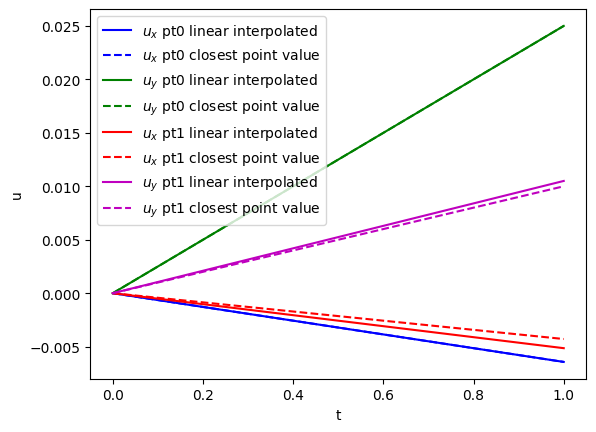

In [14]:
import vtuIO

pvdfile = vtuIO.PVDIO(f"{out_dir}/blubb.pvd", interpolation_backend="scipy", dim=2)
time = pvdfile.timesteps
points={'pt0': (0.3,0.5,0.0), 'pt1': (0.24,0.21,0.0)}
displacement_linear = pvdfile.read_time_series("displacement", points, interpolation_method="linear")
displacement_nearest = pvdfile.read_time_series("displacement", points, interpolation_method="nearest")

import matplotlib.pyplot as plt
plt.plot(time, displacement_linear["pt0"][:,0], "b-", label="$u_x$ pt0 linear interpolated")
plt.plot(time, displacement_nearest["pt0"][:,0], "b--", label="$u_x$ pt0 closest point value")
plt.plot(time, displacement_linear["pt0"][:,1], "g-", label="$u_y$ pt0 linear interpolated")
plt.plot(time, displacement_nearest["pt0"][:,1], "g--", label="$u_y$ pt0 closest point value")
plt.plot(time, displacement_linear["pt1"][:,0], "r-", label="$u_x$ pt1 linear interpolated")
plt.plot(time, displacement_nearest["pt1"][:,0], "r--", label="$u_x$ pt1 closest point value")
plt.plot(time, displacement_linear["pt1"][:,1], "m-", label="$u_y$ pt1 linear interpolated")
plt.plot(time, displacement_nearest["pt1"][:,1], "m--", label="$u_y$ pt1 closest point value")
plt.legend()
plt.xlabel("t")
plt.ylabel("u")